# DESCRIPCIÓN SISTEMA LÁSER REMOTO





- Canal emisor: compuesto por un láser de estado sólido y un emisor
- Canal receptor: telescopio de apertura a determinar

Vamos a simular primero la cadena de bombeo de Laser Raman, es decir, la ruta que va desde el laser de emisión hasta la muestra y que incluye los conectores, los switches, la fibra óptica y la lente de focalización.

### Datos del láser


In [1]:
## Datos Láser
# Energia por pulso
E_pulso = 20;       # mJ 
# Ancho de pulso
tau_pulso = 10;    # ns
# Frecuencia de repetición del láser
frp = 20;               

lambda_L = 532;  # nm

Pot_Promedio = E_pulso * frp;

### Datos de propagación

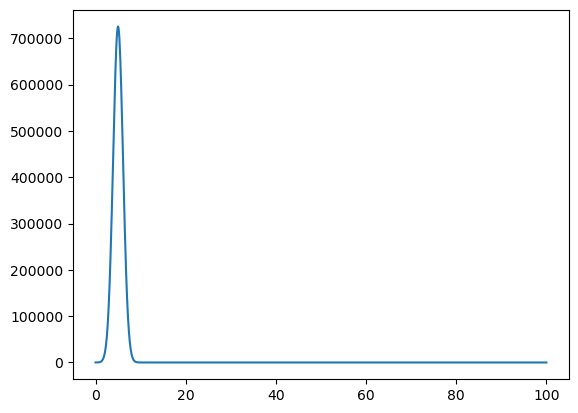

In [2]:
# Distancia a la que está el blanco
dist_sample = 1;    # km
# Atenuación atmosférica, día despejado. Depende de las condiciones atmosféricas (pagina 316 de CCD Arrays, Cameras and Displays de Holst)
#sigma_atten = 0.4;     # km^-1
# La atenuación atmosférica será muy variable, y además nuestro sistema remoto alcanzará sólo la escala de los metros.

# Diametro del haz de la muestra
diam_muestra = 10;     # mm
# El diámetro sobre la muestra lo podemos derivar de la focal del telescopio y del tamaño de la fibra de colección
# Potencia pico
Pot_pico = E_pulso * 1e-3 / (tau_pulso *1e-9);     # W emitidos del haz colimado
# Potencia muestra 
# El haz es colimado, no vamos a considerar la atenuación por la distancia al cuadrado
import numpy as np
from numpy import exp
import matplotlib.pyplot as plt
from scipy.stats import norm
#Pot_muestra = Pot_pico * exp(-sigma_atten * dist_sample);    # W
# La potencia del pulso será una gaussiana centrada en tau_pulso/2 con potencia = Pot_pico
# Número de puntos que calculamos en cada pulso
# Nt = 101;
# t = np.linspace(0,tau_pulso, Nt)     # ns
Nt = 1001;
t = np.linspace(0,tau_pulso*10, Nt)     # ns
# Pot_pulso1 = Pot_pico * np.gaussiana(tau_pulso);
# s = np.random.normal(Pot_pico, tau_pulso, Nt)
Pot_pulso1 = Pot_pico * norm.pdf (t, 5,1.1)
# Graficando Gauss
#define plot 
plt.plot(t, Pot_pulso1)
plt.show ()

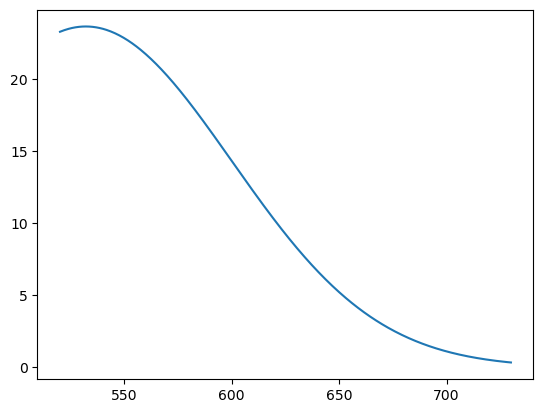

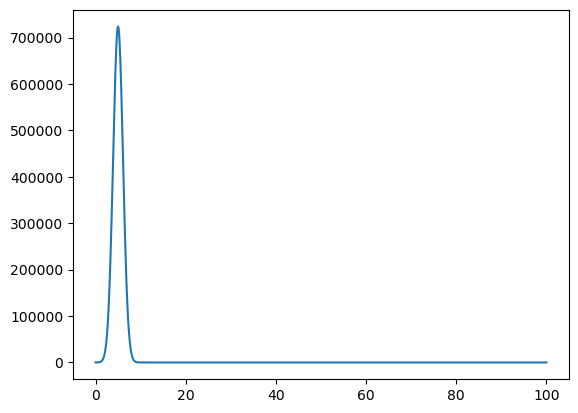

In [3]:
raman_shift = 1086e-7    # cm^-1  ---> nm^-1
# lamda = 1086;    # cm^-1
lamda_min = 520;     #nm
# lamda_max = 540;  #nm
lamda_max = 730;  #nm
# lamda = np.linspace(lamda_min,lamda_max,100)
eps_raman_Ca = 1e-8;
# Calculamos la resolución para la calcita
bandwidth_Ca = 0.4;     # nm
# Número de pasos en lamda
Nbwidth = (lamda_max - lamda_min)/bandwidth_Ca;
intNbwidth = int(Nbwidth);
decNbwidth = abs(Nbwidth) - abs(int(Nbwidth));
# Ajustamos para que el intervalo entre lamda consecutivas sea el elegido
if decNbwidth == 0:
    lamda_raman_ca = np.linspace(lamda_min,lamda_max, int(Nbwidth)+1)
else:
    lamda_raman_ca = np.linspace(lamda_min,round(lamda_max+bandwidth_Ca*(1-decNbwidth),3), int(Nbwidth)+2)

# 
Matrix = np.zeros((lamda_raman_ca.size, t.size))
for ir in range(lamda_raman_ca.size):
    # Matrix[ir, :] = np.multiply(Pot_pulso1[:] ,norm.pdf (lamda_raman_ca[ir], lambda_L,1.1))
    # Matrix[ir, :] = np.multiply(Pot_pulso1[:] ,norm.pdf (lamda_raman_ca[ir], lambda_L, lambda_L*1086*1e-7))
    # Matrix[ir, :] = Pot_pulso1[:] 
    Matrix[ir, :] = np.multiply(Pot_pulso1[:] ,np.exp(-(lamda_raman_ca[ir]-lambda_L)**2*1086e-7))

Pot_pulso = Matrix;

plt.plot(lamda_raman_ca, Pot_pulso[:, 0])
plt.show ()

# plt.plot(t, Pot_pulso[20, :])
# plt.show ()


### Calculo de la irradiancia en la muestra

In [4]:
from numpy import pi
Irr_muestra = Pot_pulso / (pi * (diam_muestra*1e2/2)**2);    # W/cm^2
print(Irr_muestra.max() /1000)     # kW/cm^2

0.0009235437954071413


### Eficiencia raman para la calcita, se emplea como referencia

In [5]:
# Irradiancia Raman
Irr_Raman = Irr_muestra*eps_raman_Ca;    # W/cm^2

La muestra se convierte en un emisor lambertiano que emite en π y su flujo debe llegar al cabezal colector que está a una distancia d. 
Convertimos la irradiancia en Radiancia (W/cm^2 str).

In [6]:
Rad_Raman = Irr_Raman/pi;   # W/cm^2 str

Esta superficie emisora es a todos los efectos puntual para el sistema de colección por lo que debemos calcular la intensidad luminosa.

In [7]:
I_emitida = Rad_Raman * (pi*(diam_muestra*1e-1/2)**2);
# Cálculo de la intensidad óptica       I = L * S

Si supongo que se observa la fuente puntual en eje entonces: I=I0cos(i) ( ver optica instrumental pagina 83).
La Irradiancia en la apertura de la óptica queda como:

In [8]:
Irr_apertura_optica = I_emitida/(dist_sample*1e5)**2;         # W/cm^2

La señal es recogida por el detector que esta a una distancia d.

In [9]:
# Diametro de apertura óptica
D_opt = 10; # cm
# Transmitancia de la óptica
tau_optica = 0.6;

Flujo_coleccion = tau_optica * Irr_apertura_optica * pi * (D_opt/2)**2;      # W que llegan a la óptica

Nota: ahora suponemos que el sisetma de colección es límite por difracción y que la mancha de airy es más
pequeña que el píxel

### Datos del SPECTROMETRO (de la red de difracción)



In [10]:
dispersion = 13;     # nm/mm dispersion del espectrometro
eficiencia = 0.5;     # spectrometer throughput
# spectral_resolution_required = 6 , 8 cm^-1   ;          0.17 , 0.23 nm
# spectral_dispersion_required = 12.6 , 17 nm/mm

### Datos del DETECTOR

In [11]:
OCG = 4.5e-6;       # V/e-
# Tamaño de pixel
px = 0.015;            # mm 
# Números de pixels
N_pixel_H = 2048;
N_pixel_V = 2048;
# Resolución
disp_pix = px * dispersion;

El espectro tiene una anchura de 0.4, 0.5 nm, el cual es recogido en los siguientes pixeles.

In [12]:
# bandwidth_Ca = 0.4;     # nm
ext = (bandwidth_Ca/disp_pix);      # pixels

### Detector data

In [13]:
# Velocidad de la luz
c = 3*1e8;         # m/s
h = 6.62*1e-34; # J*s
# Eficiencia Cuántica
QE = 0.6;
# Full well capacity
F_wc = 100*1e3;    # e-

Flujo radiante considerado a cada pixel de la señal Raman

In [14]:
print(ext)
print(np.floor(ext))
print(round(ext,9))
#Flujo_px = Flujo_coleccion * eficiencia / np.floor(ext);
Flujo_px = Flujo_coleccion * eficiencia / round(ext,9);

2.0512820512820515
2.0
2.051282051


Energía Raman recogida por el detector:

In [15]:
Flujo_px_esp = Flujo_px / bandwidth_Ca;       # W/nm per pixel

Calculamos la energía en el detector empleando $\lambda_{Raman _ Ca }$  = 564.62 nm.
No hace falta hacerlo espectralmente (lo dejamos para saber como hacerlo en otros casos), hemos estado considerándolo siempre de forma discreta:

In [16]:
def Cts_Raman (lamda, Flujo_px_esp):
    # Cts_r = np.linspace(0,0,len(lamda))
    Cts_r = np.zeros([len(lamda), t.size])
    for i1 in range(len(lamda)):
        # Cts_r[i1] =  Flujo_px_esp / (c * h) *lamda[i1] * QE;
        Cts_r[i1,:] =  Flujo_px_esp[i1, :] / (c * h) *lamda[i1] * QE;
    return Cts_r

Cts_r = Cts_Raman (lamda_raman_ca*1e-9, Flujo_px_esp);

Los fotoelectrones de la señal Raman son calculados en el rango espectral de la señal:

In [17]:
# Debemos construir la función con lamda simbólica, para ello calc
from sympy.abc import lamda
#fPot_pulso = Pot_pulso1/ (pi * (diam_muestra*1e-1/2)**2) * eps_raman_Ca / pi * (pi*(diam_muestra*1e-1/2)**2)/(dist_sample*1e5)**2*tau_optica * pi * (D_opt/2)**2 * eficiencia / round(ext)/ bandwidth_Ca 
fPot_pulso = Pot_pulso1/ (pi * (diam_muestra*1e-1/2)**2) * eps_raman_Ca / pi * (pi*(diam_muestra*1e-1/2)**2)/(dist_sample*1e5)**2*tau_optica * pi * (D_opt/2)**2 * eficiencia / round(ext, 9)/ bandwidth_Ca 
import sympy
from scipy import integrate

fPot_pulso1 = fPot_pulso *1e9 / (c * h) * QE
lamda_min = (lamda_raman_ca-bandwidth_Ca/2)*1e-9;
lamda_max = (lamda_raman_ca+bandwidth_Ca/2)*1e-9;
# print(integrate.quad(S, lamda_min[25], lamda_max[25])[0])

Cts_T_list = [];    
for i in range(len(lamda_raman_ca)):
    Cts_t_list = [];
    for ii in range(t.size):
        S = lambda lamda: fPot_pulso1[ii] * lamda * exp(-(lamda-lambda_L*1e-9)**2/(2*(1.1*1e-9)**2))/(1.1*1e-9*np.sqrt(2*pi))
        Cts_t_list.append(integrate.quad(S, lamda_min[i], lamda_max[i])[0])
    # print(i)
    Cts_T_list.append(Cts_t_list)
Cts_T = np.array(Cts_T_list)
# Con esto  tenemos la integral de Cts a cada pequeño intervalo temporal bandwidth_Ca

print(Cts_T.shape)

(526, 1001)


El número de fotoelectrones depende del tiempo de integración.
#### La energía por pulso, en cambio, no depende del tiempo.

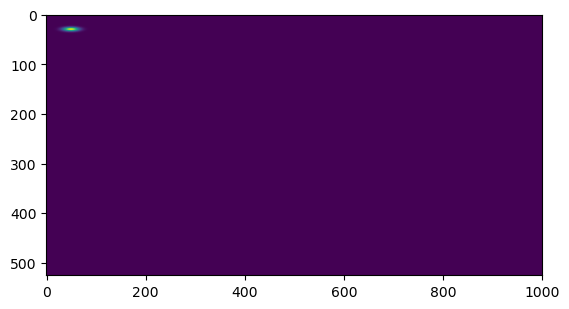

In [18]:
# Signal(t_i) = Cts_T     para todo t_i
# Fotoelectrones por segundo
# global Signal
Signal = Cts_T;

plt.imshow(Signal)
plt.show()

Transformamos los fotoelectrones detectados a Voltios.

In [19]:
# Change to V
def X(t):
    x = Signal*OCG;       #V
    return x
x = X(1);        # V

## Ruido estimado
### a) Dark Current noise


In [20]:
# signal at T = 20ºC == 293 K
s_dark = 100;               # e-/pixel/s
from numpy import sqrt
def N_dark(T, t_i):
    if np.ndim(t_i) == 1:
        if np.ndim(T) == 1:
            n = np.zeros((T.size,t_i.size))
            for i2 in range(len(t_i)):
                n[:,i2] = sqrt(s_dark * np.multiply(t_i[i2], np.multiply(1.4*1e6 * T**3,exp(-9080/T))));
        elif np.ndim(T) == 0:
            n = np.linspace(0,0,t_i.size)
            n[:] = sqrt(s_dark * t_i[:] * 1.4*1e6 * T**3 * exp(-9080/T));
    elif np.ndim(t_i) == 0:
        if np.ndim(T) == 1:
            n = np.linspace(0,0,T.size)
            n[:] = sqrt(s_dark * t_i * np.multiply(1.4*1e6 * T**3,exp(-9080/T)));
        elif np.ndim(T) == 0:
            n = sqrt(s_dark * t_i * 1.4*1e6 * T**3 * exp(-9080/T));        
    return n

### b) Read-out noise

In [21]:
# Read-out noise
global N_r
N_r = 7;     # e-

### c) Quantification noise

In [22]:
#global N_q
# bit analogic converter
n = 12;
# Nivel de digitalización para una ganancia normal
DN = F_wc / 2**n;
N_q = DN / sqrt(12);     # e-

### d) Photonic noise 

Señal Raman:

In [23]:
# Photonic noise
def N_f_R(i):
    n = sqrt(np.double(Signal[:, i]));
    return n
N_f_Raman = N_f_R(1);

## Ruido total (desviación estándar)

Ruido en función de la temperatura y el tiempo de integración.

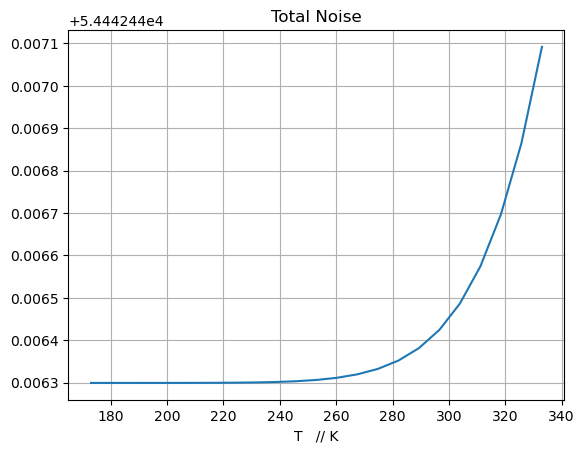

In [24]:
from numpy import linspace

#Definimos la Temperatura y tiempo de muestreo
# t_i = np.linspace(0,1,25)
t_i = t
T = linspace(173,333,23);    # K
# Calculamos la variación del ruido total con la temperatura para un intervalo 173 K a 330 K
def N_T_Total (lamda,T, t_i):
    if np.ndim(T) == 1:
        n = np.zeros((len(lamda),len(t_i),len(T)))
        for i1 in range(len(lamda)):        
            for i2 in range(len(t_i)):
                # n[i1,i2,:] = sqrt(N_q**2 + N_r**2 + N_f_R(t_i[i2])[i1]**2+N_dark(T, t_i)[:,i2]);
                n[i1,i2,:] = sqrt(N_q**2 + N_r**2 + N_f_R(i2)[i1]**2+N_dark(T, t_i[i2])[:]);
    if np.ndim(T) == 0:
        n = np.zeros((len(lamda),len(t_i)))
        # for i1 in range(len(lamda)):        
        #         n[i1,:] = sqrt(N_q**2 + N_r**2 + N_f_R(t_i[:])[i1]**2+N_dark(T, t_i[:])[:]);        
        for i2 in range(len(t_i)):        
                n[:,i2] = sqrt(N_q**2 + N_r**2 + N_f_R(i2)[:]**2+N_dark(T, t_i[i2]));        
    return n

N_Total = N_T_Total(lamda_raman_ca,T,t_i)

# Representamos el ruido total respecto lambda para un cierto T y t
import matplotlib.pyplot as plt
#plt.plot(lamda_raman_ca, N_Total[:,0,0])
#plt.plot(t_i, N_Total[20,:,0])
plt.plot(T, N_Total[20,10,:])
plt.title('Total Noise')
#plt.xlabel('$\lambda$   // nm')
#plt.xlabel('t_i   // ns')
plt.xlabel('T   // K')
plt.grid(visible=1)
plt.show()


Niveles de ruido esperados para la temperatura de operación T = 233 K

In [25]:
T_op1 = 233;       t_in = np.array([1.5, 1, 0.5, 1.25*1e-3]);
N_Total_233 = N_T_Total(lamda_raman_ca,T_op1,t_in)

## Evaluación de SNR para un cierto nivel de señal (Detección Continua)

In [26]:
# T = linspace(193, 293, 101);       
T = linspace(193, 293, 11);       
t_i1 = 0.1;     t_i2 = 0.05;    t_i3 = 0.02;    t_i4 = 0.01;
# SNR
def SNR_REAL(lamda, T, t_i):
    if np.ndim(T) == 1:    
        s = np.zeros((lamda.size,t_i.size,T.size))
        for i1 in range(t_i.size):
            for i2 in range(T.size):
                # s[:,i1,i2] = Signal[:, i1] / N_T_Total(lamda, T, t_i)[:,i1,i2];
                s[:,i1,i2] = Signal[:, i1] / N_T_Total(lamda, T[i2], t_i)[:,i1];
    elif np.ndim(T) == 0:    
        s = np.zeros((lamda.size,t_i.size))
        for i1 in range(t_i.size):
                s[:,i1] = Signal[:, i1] / N_T_Total(lamda, T, t_i)[:, i1];
    return s

SNR_1 = SNR_REAL(lamda_raman_ca, T, np.array([t_i1, t_i2,t_i3,t_i4]))
SNR_real_1 = SNR_1[:,0,:];
SNR_real_2 = SNR_1[:,1,:];
SNR_real_3 = SNR_1[:,2,:];
SNR_real_4 = SNR_1[:,3,:];

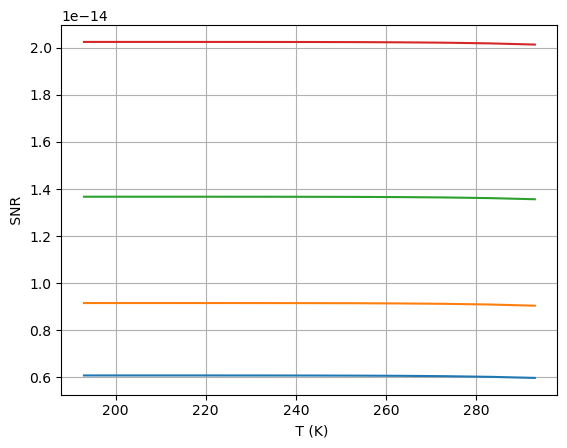

In [27]:
plt.plot(T, SNR_real_1[1,:])
plt.plot(T, SNR_real_2[1,:])
plt.plot(T, SNR_real_3[1,:])
plt.plot(T, SNR_real_4[1,:])
plt.xlabel(' T (K)')
plt.ylabel(' SNR ')
plt.grid(visible=1)
plt.show()

## Evaluación de SNR para un cierto nivel (Condición promedio)

Sea N el número de imágenes tomadas (acumulaciones).

In [28]:
NN = 20;   # Número de pulsos
# t_i = 0.1;
tau_ida_vuelta = 2*diam_muestra*1e3 / c;
# SNR Average Condition
def SNR_REAL_A(lamda, T, t_i, N):
    if np.ndim(T) == 1:    
        s = np.zeros((lamda.size,t_i.size,T.size))
        for i1 in range(t_i.size):
            for i2 in range(T.size):
                # s[:,i1,i2] = Signal[:] * N / (N_T_Total(lamda, T, t_i)[:,i1,i2] * sqrt(N));
                s[:,i1,i2] = Signal[:, i1] * N / sqrt(N_T_Total(lamda, T[i2], t_i)[:, i1]**2 * N);
    elif np.ndim(T) == 0:    
        s = np.zeros((lamda.size,t_i.size))
        for i1 in range(t_i.size):
            # s[:,i1] = Signal[:] * N / (N_T_Total(lamda, T, t_i)[:,i1] * sqrt(N));
            s[:,i1] = Signal[:, i1] * N / sqrt(N_T_Total(lamda, T, t_i[i1])[:]**2 * N);
    return s

SNR_r_A = SNR_REAL_A(lamda_raman_ca, T, np.array([t_i1, t_i2,t_i3,t_i4]), NN);
SNR_real_A1 = SNR_r_A[:,0,:];
SNR_real_A2 = SNR_r_A[:,1,:];
SNR_real_A3 = SNR_r_A[:,2,:];
SNR_real_A4 = SNR_r_A[:,3,:];

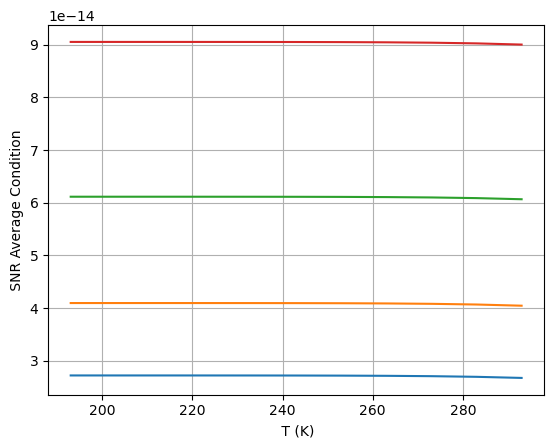

In [29]:
plt.plot(T, SNR_real_A1[1,:])
plt.plot(T, SNR_real_A2[1,:])
plt.plot(T, SNR_real_A3[1,:])
plt.plot(T, SNR_real_A4[1,:])
plt.xlabel(' T (K)')
plt.ylabel(' SNR Average Condition ')
plt.grid(visible=1)
plt.show()